# a02 Example - Gaussian Process Bayesian Optimization Using `GPBayesianOptimizeScan` implementation of `AbstractOptimizeScan`

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt

from gaussian_process_bayesian_optimization.gp_bayes_opt import bayes_opt_main

## Setup devices

In [2]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage() # Device 2

## Define a measure function

In [3]:
def voltage_response(v1, v2):
    """
    Paraboloid function to optimize.
    """
    return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1 and v2. Also adds a calculated voltage response to optimize.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)

    return d

# Define live plot

In [4]:
@ps.live_plot
def plot_optim_live(expt):
    global fig, ax, cb0, cb1
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                cmap='viridis')
    ax.set_box_aspect(1)
    if cb0 is None and cb1 is None:
        cb0 = fig.colorbar(scatter, label="optimizer step")
        cb1 = fig.colorbar(pcm, label="voltage response")
    else:
        cb0.update_normal(scatter)
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

# Define runinfo

In [5]:
runinfo = ps.RunInfo()
runinfo.measure_function = get_voltage_data

# Implement `AbstractOptimizeScan` with `GPBayesianOptimizeScan`

In [6]:
class GPBayesianOptimizeScan(ps.AbstractOptimizeScan):
    """
    Optimizes objective function using Gaussian process for Bayesian optimization.
    Bayesian optimization method `bayes_opt_main` predicts optimal next measurement from observed data.
    """

    def __init__(self, initialization_dict, prop, optimizer_inputs, sample_function_output,
                 domain_info_list,
                 dt=0., n_max=100,
                 init_scans=None, extremum='min', ei_threshold=1e-1):
        super().__init__(initialization_dict, prop, optimizer_inputs, sample_function_output,
                         dt=dt, n_max=n_max)
        self.last_optim_idx = n_max - 2
        self.domain = domain_info_list
        self.X_train = np.empty((1, len(initialization_dict)))
        self.X_train[0] = np.array(list(initialization_dict.values()))
        self.y_train = None # TODO: multidim output? np.empty((1, 1))
        self.init_scans = init_scans
        if init_scans is not None:
            self.init_scan_ct = len(init_scans)
        else:
            self.init_scan_ct = None
        self.extremum = extremum
        self.ei_threshold = ei_threshold
        self.set_final_opt = False
    
    def step_optimizer(self, index, experiment):

        def postproc_extremum(y, extremum):
            match extremum:
                case 'max':
                    return y
                case 'min':
                    return -y
                case _:
                    raise ValueError('Extremum must be max or min')
        
        def get_arg_opt(y, extremum):
            match extremum:
                case 'max':
                    return np.argmax(y)
                case 'min':
                    return np.argmin(y)
                case _:
                    raise ValueError('Extremum must be max or min')
                
        if self.set_final_opt: # set final output to best observed output
            arg_opt = get_arg_opt(experiment.__dict__[self.sample_f_out][:index], self.extremum)
            opt_in_opt = [experiment.__dict__[measurement][arg_opt] for measurement in self.opt_in]
            self.running = False
            return opt_in_opt
        else:
            if index == 1: # first optim step after init
                self.y_train = np.empty(1)
                self.y_train[0] = postproc_extremum(experiment.__dict__[self.sample_f_out][0], self.extremum)
            else: # update observed data with latest optimized measurement
                i_prev = index - 1
                self.X_train = np.append(self.X_train, [[experiment.__dict__[measurement][i_prev] for measurement in self.opt_in]], axis=0)
                self.y_train = np.append(self.y_train, [postproc_extremum(experiment.__dict__[self.sample_f_out][i_prev], self.extremum)], axis=0)
            if self.init_scan_ct is not None and index <= self.init_scan_ct: # non-optimized measurement points to intialize Gaussian process
                i_prev = index - 1
                f_in_next = self.init_scans[i_prev]
                return f_in_next
            else: # optimize next measurement
                f_in_next, keep_running = bayes_opt_main(self.domain, self.X_train, self.y_train, ei_threshold=self.ei_threshold)
                self.set_final_opt = not keep_running or not (index < self.last_optim_idx)
                return f_in_next.numpy().astype(np.float64)
            

# Instantiate OptimizeScan

In [7]:
runinfo.scan0 = GPBayesianOptimizeScan({'v1': 1., 'v2': 1.}, 'voltage', ('v1_readout', 'v2_readout'), 'vf',
                                     [(0, 10, .1), (0, 10, .1)],
                                     dt=1., n_max=100,
                                     init_scans=[[9., 1.], [9., 9.], [1., 9.]],
                                     extremum='min', ei_threshold=1e-2)

# Run Experiments

In [ ]:
expt = ps.Experiment(runinfo, devices)
expt.start_thread()

PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
PyTorch version: 2.8.0+cpu
Computation successful on: cpu
Stopping Experiment


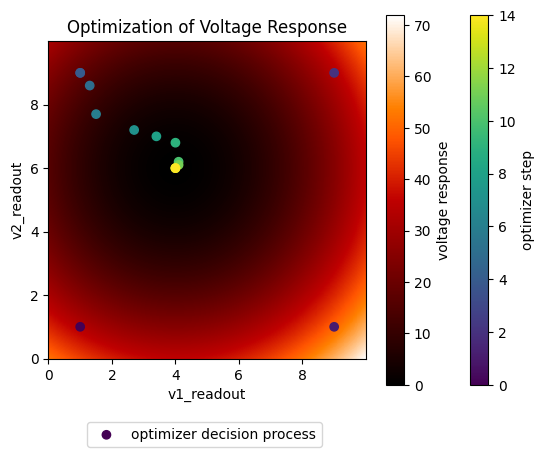

In [9]:
fig, ax = plt.subplots()
cb0 = cb1 = None
try:
    plot_optim_live(expt)
except KeyboardInterrupt:
    expt.stop()

In [10]:
expt.__dict__

{'runinfo': <pyscan.measurement.run_info.RunInfo at 0x21f8adba4e0>,
 'devices': <itemattribute.item_attribute.ItemAttribute at 0x21fce2f0ce0>,
 'expt_thread': <Thread(Thread-3 (run), stopped daemon 39240)>,
 'iteration': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 'v1_readout': array([1.        , 9.        , 9.        , 1.        , 1.        ,
        1.29999995, 1.5       , 2.70000005, 3.4000001 , 4.        ,
        4.0999999 , 4.0999999 , 4.        , 4.        , 4.        ]),
 'v2_readout': array([1.        , 1.        , 9.        , 9.        , 9.        ,
        8.60000038, 7.69999981, 7.19999981, 7.        , 6.80000019,
        6.19999981, 6.0999999 , 6.        , 6.        , 6.        ]),
 'vf': array([3.40000000e+01, 5.00000000e+01, 3.40000000e+01, 1.80000000e+01,
        1.80000000e+01, 1.40500022e+01, 9.13999935e+00, 3.12999942e+00,
        1.35999989e+00, 6.40000305e-01, 4.99999046e-02, 1.99999619e-02,
        0.00000000e+00, 0

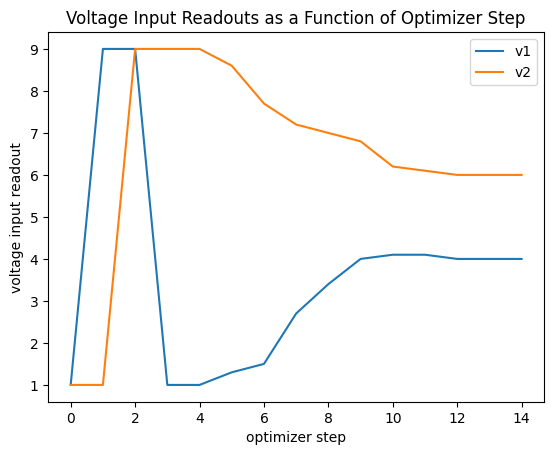

In [11]:
plt.plot(list(zip(expt.v1_readout, expt.v2_readout)))
plt.legend(['v1', 'v2'])
plt.xlabel("optimizer step")
plt.ylabel("voltage input readout")
plt.title("Voltage Input Readouts as a Function of Optimizer Step");

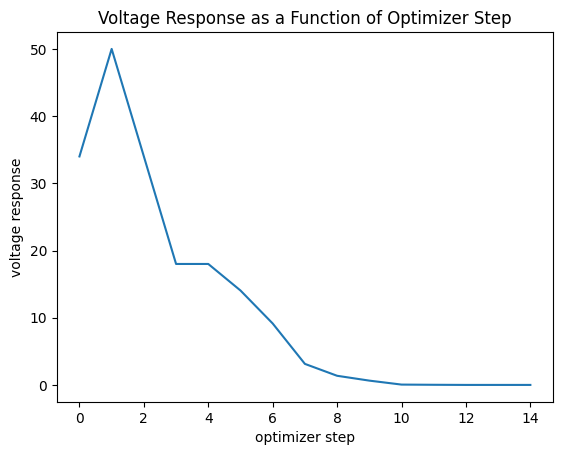

In [12]:
plt.plot(expt.vf)
plt.xlabel("optimizer step")
plt.ylabel("voltage response")
plt.title("Voltage Response as a Function of Optimizer Step");

In [13]:
def plot_optim_pcm():
    fig, ax = plt.subplots()
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                         cmap='viridis')
    ax.set_box_aspect(1)
    fig.colorbar(scatter, label="optimizer step")
    fig.colorbar(pcm, label="voltage response")
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

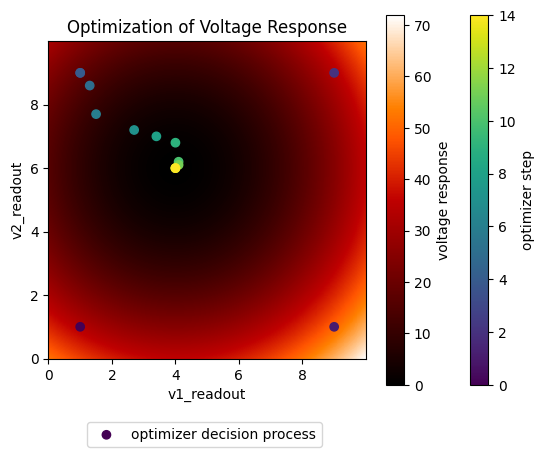

In [14]:
plot_optim_pcm()

In [15]:
def plot_optim_3d(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    ax.plot_surface(x, y, z, color='C1', alpha=.5)
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, expt.vf, c=range(len(expt.v1_readout)))
    ax.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(scatter, label="optimizer step", pad=.1)
    ax.legend(["voltage response function", "optimizer decision process",], loc='lower left', bbox_to_anchor=(.2, -.2))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_zlabel("voltage response")
    ax.set_title("Optimization of Voltage Response")

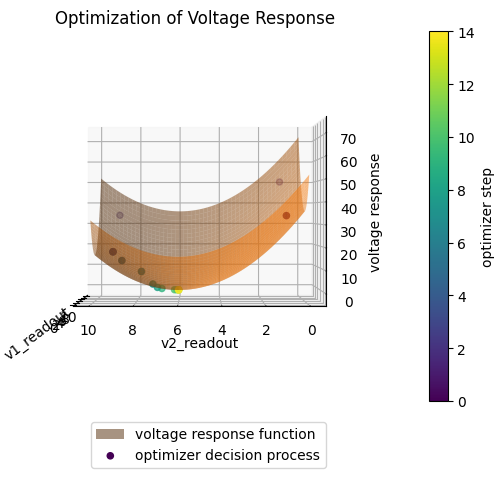

In [16]:
plot_optim_3d(0, 180)

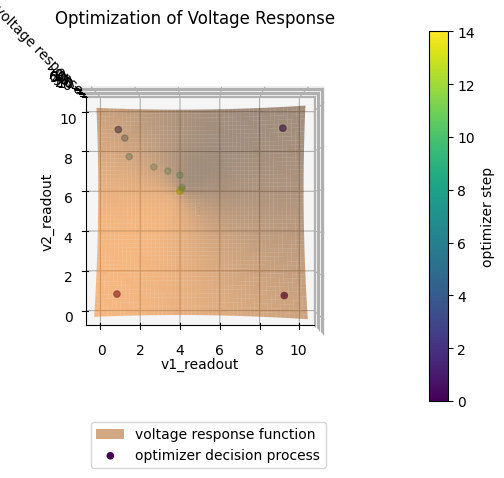

In [17]:
plot_optim_3d(90, 270)

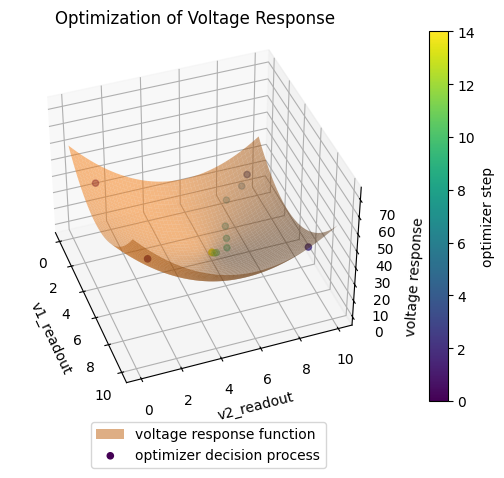

In [18]:
plot_optim_3d(40,-20)